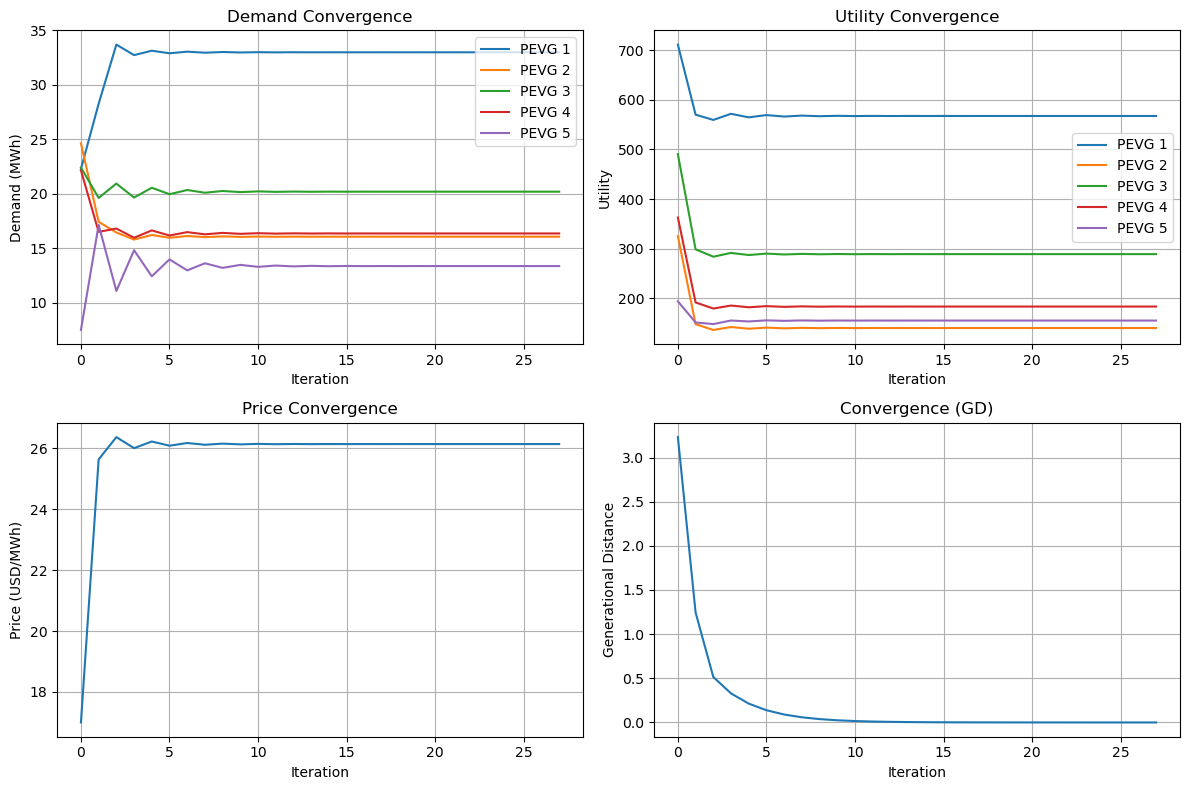


Final Results:
Optimal Price: 26.14 USD/MWh
Final Demands: [32.99182855 16.06866894 20.20113194 16.36551452 13.37285604]
Final Utilities: [567.53014784 140.31017272 289.2287264  183.5964095  155.36955288]
Grid Revenue: 2587.68 USD


In [1]:
import numpy as np
import matplotlib.pyplot as plt

class StackelbergChargingGame:
    def __init__(self, 
                 N: int = 5,           # Number of PEVGs
                 C: float = 99.0,      # Grid capacity in MWh
                 b_range: tuple = (35.0, 65.0),  # Battery capacity range
                 s_range: tuple = (1.0, 2.0),   # Satisfaction parameter range
                 p_init: float = 17.0):         # Initial price
        self.N = N
        self.C = C
        self.p = p_init
        
        # Randomly initialize parameters
        self.b = np.random.uniform(b_range[0], b_range[1], N)  # Battery capacities
        self.s = np.random.uniform(s_range[0], s_range[1], N)  # Satisfaction parameters
        
        # Initial demands
        self.x = np.random.uniform(0, C/N, N)
        self.x = self.x * (C / np.sum(self.x))  # Normalize to satisfy constraint
        
        # History for plotting
        self.x_history = []
        self.u_history = []
        self.p_history = []
        self.lambda_history = []

    def utility(self, x: np.ndarray, p: float) -> np.ndarray:
        """Calculate utility for each PEVG"""
        return self.b * x - 0.5 * self.s * x**2 - p * x

    def grid_revenue(self, x: np.ndarray, p: float) -> float:
        """Calculate grid revenue"""
        return p * np.sum(x)

    def projection(self, x: np.ndarray) -> np.ndarray:
        """Project onto feasible set: sum(x) <= C, x >= 0"""
        x_proj = np.maximum(x, 0)
        total = np.sum(x_proj)
        if total > self.C:
            x_proj = x_proj * (self.C / total)
        return x_proj

    def s_s_iteration(self, x: np.ndarray, p: float) -> np.ndarray:
        """One iteration of Solodov-Svaiter hyperplane projection"""
        # Gradient of negative utility
        F = self.s * x + p - self.b
        
        # First projection
        z = self.projection(x - F)
        r = x - z
        
        if np.allclose(r, 0):
            return z
            
        # Hyperplane construction
        alpha = np.dot(r, r) / np.dot(r, F)
        w = x - alpha * F
        
        # Second projection onto intersection
        x_new = self.projection(w)
        return x_new

    def calculate_lambda(self, x: np.ndarray, p: float) -> np.ndarray:
        """Calculate Lagrange multipliers"""
        F = self.s * x + p - self.b
        total_demand = np.sum(x)
        if np.isclose(total_demand, self.C):
            return np.maximum(F, 0)
        return np.zeros(self.N)

    def generational_distance(self, x: np.ndarray, x_star: np.ndarray) -> float:
        """Calculate Generational Distance to equilibrium solution"""
        return np.sqrt(np.sum((x - x_star)**2)) / self.N

    def optimize(self, max_iter: int = 100, tol: float = 1e-4):
        """Run the Stackelberg game optimization"""
        # Equilibrium solution for GD (computed analytically)
        x_star = np.clip((self.b - self.p) / self.s, 0, None)
        if np.sum(x_star) > self.C:
            lambda_star = (np.sum(self.b / self.s) - self.C) / np.sum(1 / self.s)
            x_star = (self.b - lambda_star) / self.s
            x_star = np.maximum(x_star, 0)
        
        gd_history = []
        
        for k in range(max_iter):
            # Store current state
            self.x_history.append(self.x.copy())
            self.u_history.append(self.utility(self.x, self.p))
            self.p_history.append(self.p)
            lambdas = self.calculate_lambda(self.x, self.p)
            self.lambda_history.append(lambdas)
            
            # Calculate GD
            gd = self.generational_distance(self.x, x_star)
            gd_history.append(gd)
            
            # Update demands using S-S method
            x_new = self.s_s_iteration(self.x, self.p)
            
            # Check convergence
            if np.allclose(self.x, x_new, atol=tol) and np.allclose(lambdas, lambdas[0], atol=tol):
                # Optimize price
                self.p = np.mean(self.b - self.s * self.x)  # Approximation from (28)
                self.x_history.append(self.x.copy())
                self.u_history.append(self.utility(self.x, self.p))
                self.p_history.append(self.p)
                self.lambda_history.append(self.calculate_lambda(self.x, self.p))
                gd_history.append(self.generational_distance(self.x, x_star))
                break
                
            self.x = x_new
            
            # Optimize price (simplified)
            self.p = np.mean(self.b - self.s * self.x)
        
        return gd_history

    def plot_results(self, gd_history: list):
        """Plot convergence results"""
        iterations = len(self.x_history)
        
        # Demand convergence
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        for i in range(self.N):
            plt.plot([x[i] for x in self.x_history], label=f'PEVG {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('Demand (MWh)')
        plt.title('Demand Convergence')
        plt.legend()
        plt.grid(True)
        
        # Utility convergence
        plt.subplot(2, 2, 2)
        for i in range(self.N):
            plt.plot([u[i] for u in self.u_history], label=f'PEVG {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('Utility')
        plt.title('Utility Convergence')
        plt.legend()
        plt.grid(True)
        
        # Price convergence
        plt.subplot(2, 2, 3)
        plt.plot(self.p_history)
        plt.xlabel('Iteration')
        plt.ylabel('Price (USD/MWh)')
        plt.title('Price Convergence')
        plt.grid(True)
        
        # GD convergence
        plt.subplot(2, 2, 4)
        plt.plot(gd_history)
        plt.xlabel('Iteration')
        plt.ylabel('Generational Distance')
        plt.title('Convergence (GD)')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# Test the implementation
if __name__ == "__main__":
    game = StackelbergChargingGame(
        N=5,
        C=99.0,
        b_range=(35.0, 65.0),
        s_range=(1.0, 2.0),
        p_init=17.0
    )
    
    gd_history = game.optimize(max_iter=100)
    game.plot_results(gd_history)
    
    print("\nFinal Results:")
    print(f"Optimal Price: {game.p:.2f} USD/MWh")
    print(f"Final Demands: {game.x}")
    print(f"Final Utilities: {game.utility(game.x, game.p)}")
    print(f"Grid Revenue: {game.grid_revenue(game.x, game.p):.2f} USD")

Iteration 0: Repository size = 50
Iteration 50: Repository size = 10
Iteration 100: Repository size = 45
Iteration 150: Repository size = 14


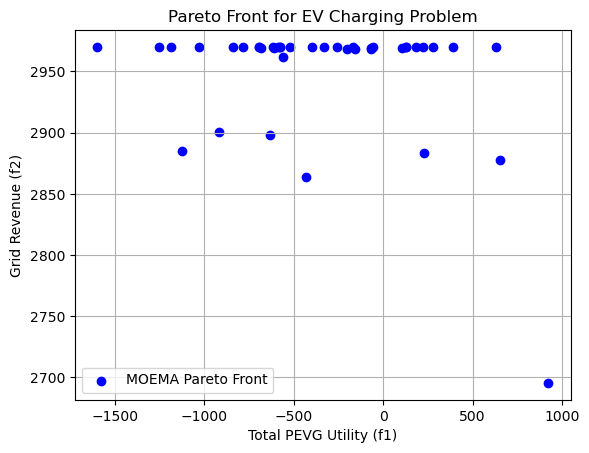


Sample Pareto Solutions:
Solution 1:
  Demands: [69.04141977  0.22992703  2.92391604 14.59184401 12.21289315]
  Price: 30.00
  Utility: -1598.80, Revenue: 2970.00
Solution 2:
  Demands: [46.37187017  0.21079187  7.17501104 15.11085986 30.13146706]
  Price: 29.99
  Utility: -66.06, Revenue: 2969.11
Solution 3:
  Demands: [32.18351937  0.19541263  6.42027175 52.18615609  8.01464015]
  Price: 30.00
  Utility: -396.52, Revenue: 2970.00
Solution 4:
  Demands: [32.36379364  0.19333994  4.74973844 14.86551132 46.82761667]
  Price: 29.99
  Utility: -67.06, Revenue: 2968.63
Solution 5:
  Demands: [34.49113135  0.19541711 14.13629026  7.84842463 42.32873666]
  Price: 29.99
  Utility: 105.05, Revenue: 2969.36


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

class MOEMA_Charging:
    def __init__(self,
                 N: int = 5,              # Number of PEVGs
                 C: float = 99.0,         # Grid capacity in MWh
                 b_range: tuple = (35.0, 65.0),  # Battery capacity range
                 s_range: tuple = (1.0, 2.0),   # Satisfaction parameter range
                 p_range: tuple = (10.0, 30.0), # Price range
                 n_particles: int = 50,
                 max_iterations: int = 200,
                 ls_iterations: int = 10):
        self.N = N
        self.C = C
        self.b = np.random.uniform(b_range[0], b_range[1], N)
        self.s = np.random.uniform(s_range[0], s_range[1], N)
        
        # Particle dimensions: N demands + 1 price
        self.m = N + 1
        self.n_particles = n_particles
        self.max_it = max_iterations
        self.ls_it = ls_iterations
        
        # Bounds: demands [0, C], price [p_min, p_max]
        self.bounds = [(0.0, C)] * N + [p_range]
        
        # Initialize particles: [x1, x2, ..., xN, p]
        self.particles = np.zeros((n_particles, self.m))
        for i in range(N):
            self.particles[:, i] = np.random.uniform(0, C/N, n_particles)
        self.particles[:, N] = np.random.uniform(p_range[0], p_range[1], n_particles)
        self.normalize_demands()
        
        self.repository = []  # Pareto front solutions
        self.delta = 0.3     # Initial local search parameter

    def normalize_demands(self):
        """Normalize demands to satisfy sum(x_n) <= C"""
        for i in range(self.n_particles):
            demands = self.particles[i, :-1]
            if np.sum(demands) > self.C:
                self.particles[i, :-1] = demands * (self.C / np.sum(demands))

    def evaluate_objectives(self, particle: np.ndarray) -> np.ndarray:
        """Calculate objectives: total utility and revenue"""
        x = particle[:-1]  # Demands
        p = particle[-1]   # Price
        
        # Total utility
        f1 = np.sum(self.b * x - 0.5 * self.s * x**2 - p * x)
        # Revenue
        f2 = p * np.sum(x)
        
        return np.array([f1, f2])

    def dominates(self, obj1: np.ndarray, obj2: np.ndarray) -> bool:
        """Check if obj1 dominates obj2"""
        return all(obj1 >= obj2) and any(obj1 > obj2)

    def update_repository(self, objectives: np.ndarray) -> None:
        """Update Pareto front repository"""
        new_repo = []
        for i, obj in enumerate(objectives):
            dominated = False
            for repo_obj in self.repository + [(self.particles[i], obj)]:
                if repo_obj[1] is not obj and self.dominates(repo_obj[1], obj):
                    dominated = True
                    break
            if not dominated:
                new_repo.append((self.particles[i].copy(), obj))
        
        # Limit repository size using crowding distance
        if len(new_repo) > 100:
            sorted_by_f1 = sorted(new_repo, key=lambda x: x[1][0])
            distances = [float('inf')] + [np.linalg.norm(sorted_by_f1[i+1][1] - sorted_by_f1[i][1])
                                        for i in range(len(sorted_by_f1)-1)] + [float('inf')]
            self.repository = [x[0] for x in sorted(zip(sorted_by_f1, distances),
                                                  key=lambda x: x[1], reverse=True)][:100]
        else:
            self.repository = new_repo

    def calculate_charge(self, objectives: np.ndarray) -> np.ndarray:
        """Calculate average charge across objectives"""
        charges = np.zeros(self.n_particles)
        best_particle = self.repository[0][0] if self.repository else self.particles[0]
        best_objs = self.evaluate_objectives(best_particle)
        
        for j in range(2):
            obj_values = objectives[:, j]
            best_value = best_objs[j]
            charge_j = np.exp(-self.m * (obj_values - best_value) /
                            (np.sum(obj_values - best_value) + 1e-10))
            charges += charge_j / 2.0
        return charges

    def calculate_force(self, charges: np.ndarray) -> np.ndarray:
        """Calculate total force vector"""
        forces = np.zeros((self.n_particles, self.m))
        objectives = np.array([self.evaluate_objectives(p) for p in self.particles])
        
        for i in range(self.n_particles):
            total_force = np.zeros(self.m)
            for j in range(self.n_particles):
                if i != j:
                    diff = self.particles[j] - self.particles[i]
                    distance = np.linalg.norm(diff) ** 2 + 1e-10
                    if self.dominates(objectives[j], objectives[i]):
                        force = (diff * charges[i] * charges[j]) / distance
                    else:
                        force = -(diff * charges[i] * charges[j]) / distance
                    total_force += force
            forces[i] = total_force
        return forces

    def improved_local_search(self, iteration: int) -> None:
        """Adaptive local search"""
        self.delta = (1 / (2 * self.max_it)) ** (iteration / self.max_it) * 0.3
        length = self.delta * (self.C - 0.0)  # Using C as reference range
        
        for i in range(self.n_particles):
            z = self.particles[i].copy()
            counter = 0
            while counter < self.ls_it:
                for k in range(self.m):
                    z[k] += (2 * np.random.random() - 1) * length
                    z[k] = np.clip(z[k], self.bounds[k][0], self.bounds[k][1])
                self.normalize_demands_particle(z)
                z_objs = self.evaluate_objectives(z)
                curr_objs = self.evaluate_objectives(self.particles[i])
                if self.dominates(z_objs, curr_objs):
                    self.particles[i] = z.copy()
                    counter = self.ls_it - 1
                counter += 1

    def normalize_demands_particle(self, particle: np.ndarray) -> None:
        """Normalize demands in a single particle"""
        demands = particle[:-1]
        if np.sum(demands) > self.C:
            particle[:-1] = demands * (self.C / np.sum(demands))

    def move_particles(self, forces: np.ndarray) -> None:
        """Move particles with attraction to best solution"""
        best_particle = self.repository[0][0] if self.repository else self.particles[0]
        
        for i in range(self.n_particles):
            force_norm = forces[i] / (np.linalg.norm(forces[i]) + 1e-10)
            rng = np.minimum(
                [b[1] - self.particles[i, j] for j, b in enumerate(self.bounds)],
                [self.particles[i, j] - b[0] for j, b in enumerate(self.bounds)]
            )
            self.particles[i] += (np.random.random() * force_norm * rng +
                               np.random.random() * (best_particle - self.particles[i]))
            for j in range(self.m):
                self.particles[i, j] = np.clip(self.particles[i, j], self.bounds[j][0], self.bounds[j][1])
            self.normalize_demands_particle(self.particles[i])

    def optimize(self) -> None:
        """Main optimization loop"""
        for iteration in range(self.max_it):
            objectives = np.array([self.evaluate_objectives(p) for p in self.particles])
            self.update_repository(objectives)
            charges = self.calculate_charge(objectives)
            self.improved_local_search(iteration)
            forces = self.calculate_force(charges)
            self.move_particles(forces)
            
            if iteration % 50 == 0:
                print(f"Iteration {iteration}: Repository size = {len(self.repository)}")

    def plot_pareto_front(self) -> None:
        """Plot the Pareto front"""
        objectives = np.array([r[1] for r in self.repository])
        
        plt.scatter(objectives[:, 0], objectives[:, 1], c='blue', label='MOEMA Pareto Front')
        plt.xlabel('Total PEVG Utility (f1)')
        plt.ylabel('Grid Revenue (f2)')
        plt.title('Pareto Front for EV Charging Problem')
        plt.legend()
        plt.grid(True)
        plt.show()

# Test the implementation
if __name__ == "__main__":
    moema = MOEMA_Charging(
        N=5,
        C=99.0,
        b_range=(35.0, 65.0),
        s_range=(1.0, 2.0),
        p_range=(10.0, 30.0),
        n_particles=50,
        max_iterations=200,
        ls_iterations=10
    )
    
    moema.optimize()
    moema.plot_pareto_front()
    
    # Print sample solutions
    print("\nSample Pareto Solutions:")
    for i, (particle, obj) in enumerate(moema.repository[:5]):
        print(f"Solution {i+1}:")
        print(f"  Demands: {particle[:-1]}")
        print(f"  Price: {particle[-1]:.2f}")
        print(f"  Utility: {obj[0]:.2f}, Revenue: {obj[1]:.2f}")

Iteration 0: Pareto front size = 25
Iteration 20: Pareto front size = 278
Iteration 40: Pareto front size = 580
Iteration 60: Pareto front size = 766
Iteration 80: Pareto front size = 851


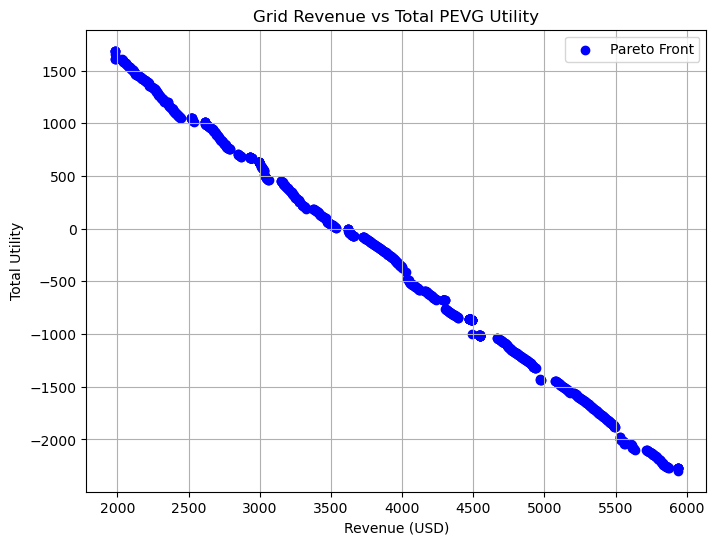


Sample Pareto Solutions:
Solution 1: Utility = -1325.13, Revenue = 4937.44
Solution 2: Utility = -1882.45, Revenue = 5495.30
Solution 3: Utility = -370.22, Revenue = 3999.72
Solution 4: Utility = 752.84, Revenue = 2789.74
Solution 5: Utility = -1323.28, Revenue = 4935.57


In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_pevgs = 5  # Number of PEVGs
grid_capacity = 99  # Total energy available from the grid (MWh)
max_iterations = 100  # Maximum number of iterations
population_size = 100  # Number of particles
local_search_iterations = 10  # Number of local search iterations
delta = 0.5  # Initial local search parameter

# Bounds
price_lower_bound = 20  # Lower bound for price (USD/MWh)
price_upper_bound = 60  # Upper bound for price (USD/MWh)
battery_capacity_lower_bound = 35  # Lower bound for battery capacity (MWh)
battery_capacity_upper_bound = 65  # Upper bound for battery capacity (MWh)

# Initialize random parameters
battery_capacities = np.random.uniform(battery_capacity_lower_bound, battery_capacity_upper_bound, num_pevgs)
satisfaction_parameters = np.random.uniform(1, 2, num_pevgs)

def initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound):
    population = []
    for _ in range(population_size):
        energy_demands = np.random.uniform(0, grid_capacity, num_pevgs)
        energy_demands = energy_demands / np.sum(energy_demands) * grid_capacity  # Normalize to grid capacity
        price = np.random.uniform(price_lower_bound, price_upper_bound)
        population.append((energy_demands.copy(), price))
    return population

# Utility function for PEVGs (total utility)
def utility_function(energy_demands, price, battery_capacities, satisfaction_parameters):
    utilities = battery_capacities * energy_demands - 0.5 * satisfaction_parameters * energy_demands**2 - price * energy_demands
    return np.sum(utilities)  # Return total utility

# Revenue function for the grid
def revenue_function(energy_demands, price):
    return price * np.sum(energy_demands)

# Constraint handling
def handle_constraints(energy_demands, grid_capacity):
    total_demand = np.sum(energy_demands)
    if total_demand > grid_capacity:
        energy_demands = energy_demands / total_demand * grid_capacity
    return np.clip(energy_demands, 0, grid_capacity)

# Local search
def local_search(particle, battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound):
    energy_demands, price = particle
    for _ in range(local_search_iterations):
        new_energy_demands = energy_demands + delta * np.random.uniform(-1, 1, num_pevgs)
        new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
        new_price = price + delta * np.random.uniform(-1, 1)
        new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
        new_utility = utility_function(new_energy_demands, new_price, battery_capacities, satisfaction_parameters)
        new_revenue = revenue_function(new_energy_demands, new_price)
        curr_utility = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
        curr_revenue = revenue_function(energy_demands, price)
        if dominates((new_utility, new_revenue), (curr_utility, curr_revenue)):
            energy_demands, price = new_energy_demands, new_price
    return energy_demands, price

# Dominance check (maximization problem)
def dominates(solution1, solution2):
    # solution1: (utility1, revenue1), solution2: (utility2, revenue2)
    # For maximization, solution1 dominates if it’s >= in all and > in at least one
    return (solution1[0] >= solution2[0] and solution1[1] >= solution2[1] and
            (solution1[0] > solution2[0] or solution1[1] > solution2[1]))

# Update Pareto front
def update_pareto_front(pareto_front, new_solution):
    # new_solution is a tuple (utility, revenue)
    if not pareto_front:
        return [new_solution]
    to_remove = []
    dominated = False
    for i, solution in enumerate(pareto_front):
        if dominates(solution, new_solution):
            dominated = True
            break
        if dominates(new_solution, solution):
            to_remove.append(i)
    if not dominated:
        pareto_front = [sol for j, sol in enumerate(pareto_front) if j not in to_remove]
        pareto_front.append(new_solution)
    return pareto_front

# Calculate charges (simplified EMA-style)
def calculate_charges(fitness_values):
    max_utility = max(f[0] for f in fitness_values)
    max_revenue = max(f[1] for f in fitness_values)
    charges = []
    for utility, revenue in fitness_values:
        q = np.exp(-num_pevgs * ((max_utility - utility) + (max_revenue - revenue)) /
                  (max_utility + max_revenue + 1e-10))
        charges.append(q)
    return np.array(charges)

# EMA algorithm
def ema_algorithm(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, population_size, max_iterations, delta, price_lower_bound, price_upper_bound):
    population = initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound)
    pareto_front = []  # List of (utility, revenue) tuples
    
    for iteration in range(max_iterations):
        # Evaluate fitness for all particles
        fitness_values = []
        for energy_demands, price in population:
            utility = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
            revenue = revenue_function(energy_demands, price)
            fitness_values.append((utility, revenue))
        
        # Update Pareto front
        for fitness in fitness_values:
            pareto_front = update_pareto_front(pareto_front, fitness)
        
        # Calculate charges
        charges = calculate_charges(fitness_values)
        
        # Calculate forces
        forces = []
        for i in range(population_size):
            force = np.zeros(num_pevgs + 1)
            for j in range(population_size):
                if i != j and charges[j] > charges[i]:  # Only attract to better solutions
                    particle_j = np.concatenate((population[j][0], [population[j][1]]))
                    particle_i = np.concatenate((population[i][0], [population[i][1]]))
                    diff = particle_j - particle_i
                    dist = np.linalg.norm(diff) + 1e-10
                    force += charges[j] * diff / dist**2
                    forces.append(force)
        
        # Move particles
        for i in range(population_size):
            energy_demands, price = population[i]
            force = forces[i]
            new_energy_demands = energy_demands + delta * force[:-1]
            new_price = price + delta * force[-1]
            new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
            new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
            population[i] = (new_energy_demands, new_price)
        
        # Local search
        for i in range(population_size):
            population[i] = local_search(population[i], battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound)
        
        if iteration % 20 == 0:
            print(f"Iteration {iteration}: Pareto front size = {len(pareto_front)}")
    
    return pareto_front, population

# Run EMA algorithm
pareto_front, particles = ema_algorithm(
    num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters,
    population_size, max_iterations, delta, price_lower_bound, price_upper_bound
)

# Extract X (revenue) and Y (utility) for plotting
X = [sol[1] for sol in pareto_front]  # Revenue
Y = [sol[0] for sol in pareto_front]  # Utility

# Plot Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, color="b", label="Pareto Front")
plt.title("Grid Revenue vs Total PEVG Utility")
plt.xlabel("Revenue (USD)")
plt.ylabel("Total Utility")
plt.legend()
plt.grid(True)
plt.show()

# Print sample solutions
print("\nSample Pareto Solutions:")
for i, (utility, revenue) in enumerate(pareto_front[:5]):
    print(f"Solution {i+1}: Utility = {utility:.2f}, Revenue = {revenue:.2f}")

Iteration 0: Pareto front size = 35
Iteration 20: Pareto front size = 100
Iteration 40: Pareto front size = 100
Iteration 60: Pareto front size = 100
Iteration 80: Pareto front size = 100


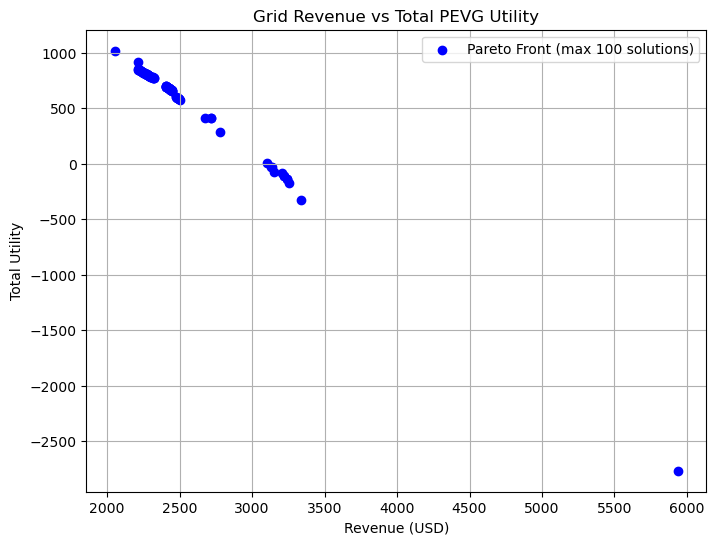


Sample Pareto Solutions:
Solution 1: Utility = 1016.42, Revenue = 2051.36
Solution 2: Utility = -2766.32, Revenue = 5940.00
Solution 3: Utility = -176.89, Revenue = 3251.45
Solution 4: Utility = 847.60, Revenue = 2211.37
Solution 5: Utility = 413.13, Revenue = 2715.09


In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_pevgs = 5
grid_capacity = 99
max_iterations = 100
population_size = 100
local_search_iterations = 10
delta = 0.5

# Bounds
price_lower_bound = 20
price_upper_bound = 60
battery_capacity_lower_bound = 35
battery_capacity_upper_bound = 65

# Initialize random parameters
battery_capacities = np.random.uniform(battery_capacity_lower_bound, battery_capacity_upper_bound, num_pevgs)
satisfaction_parameters = np.random.uniform(1, 2, num_pevgs)

def initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound):
    population = []
    for _ in range(population_size):
        energy_demands = np.random.uniform(0, grid_capacity, num_pevgs)
        energy_demands = energy_demands / np.sum(energy_demands) * grid_capacity
        price = np.random.uniform(price_lower_bound, price_upper_bound)
        population.append((energy_demands.copy(), price))
    return population

def utility_function(energy_demands, price, battery_capacities, satisfaction_parameters):
    utilities = battery_capacities * energy_demands - 0.5 * satisfaction_parameters * energy_demands**2 - price * energy_demands
    return np.sum(utilities)

def revenue_function(energy_demands, price):
    return price * np.sum(energy_demands)

def handle_constraints(energy_demands, grid_capacity):
    total_demand = np.sum(energy_demands)
    if total_demand > grid_capacity:
        energy_demands = energy_demands / total_demand * grid_capacity
    return np.clip(energy_demands, 0, grid_capacity)

def local_search(particle, battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound):
    energy_demands, price = particle
    for _ in range(local_search_iterations):
        new_energy_demands = energy_demands + delta * np.random.uniform(-1, 1, num_pevgs)
        new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
        new_price = price + delta * np.random.uniform(-1, 1)
        new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
        new_utility = utility_function(new_energy_demands, new_price, battery_capacities, satisfaction_parameters)
        new_revenue = revenue_function(new_energy_demands, new_price)
        curr_utility = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
        curr_revenue = revenue_function(energy_demands, price)
        if dominates((new_utility, new_revenue), (curr_utility, curr_revenue)):
            energy_demands, price = new_energy_demands, new_price
    return energy_demands, price

def dominates(solution1, solution2):
    return (solution1[0] >= solution2[0] and solution1[1] >= solution2[1] and
            (solution1[0] > solution2[0] or solution1[1] > solution2[1]))

def crowding_distance(pareto_front):
    """Calculate crowding distance for pruning Pareto front"""
    if len(pareto_front) <= 2:
        return [float('inf')] * len(pareto_front)
    
    # Sort by utility (objective 1)
    sorted_by_utility = sorted(enumerate(pareto_front), key=lambda x: x[1][0])
    distances = [0.0] * len(pareto_front)
    max_utility = sorted_by_utility[-1][1][0]
    min_utility = sorted_by_utility[0][1][0]
    max_revenue = max(sol[1] for sol in pareto_front)
    min_revenue = min(sol[1] for sol in pareto_front)
    
    # Set infinity for boundary points
    distances[sorted_by_utility[0][0]] = float('inf')
    distances[sorted_by_utility[-1][0]] = float('inf')
    
    # Calculate distances for interior points
    for i in range(1, len(pareto_front) - 1):
        idx = sorted_by_utility[i][0]
        prev_utility = sorted_by_utility[i-1][1][0]
        next_utility = sorted_by_utility[i+1][1][0]
        prev_revenue = sorted_by_utility[i-1][1][1]
        next_revenue = sorted_by_utility[i+1][1][1]
        dist = (((next_utility - prev_utility) / (max_utility - min_utility + 1e-10)) +
                ((next_revenue - prev_revenue) / (max_revenue - min_revenue + 1e-10)))
        distances[idx] = dist
    
    return distances

def update_pareto_front(pareto_front, new_solution, max_size=100):
    """Update Pareto front and limit to max_size using crowding distance"""
    if not pareto_front:
        return [new_solution]
    
    to_remove = []
    dominated = False
    for i, solution in enumerate(pareto_front):
        if dominates(solution, new_solution):
            dominated = True
            break
        if dominates(new_solution, solution):
            to_remove.append(i)
    
    if not dominated:
        pareto_front = [sol for j, sol in enumerate(pareto_front) if j not in to_remove]
        pareto_front.append(new_solution)
    
    # Limit to 100 solutions using crowding distance
    if len(pareto_front) > max_size:
        distances = crowding_distance(pareto_front)
        # Pair solutions with their distances and sort by distance (descending)
        sorted_pairs = sorted(zip(pareto_front, distances), key=lambda x: x[1], reverse=True)
        # Keep top max_size solutions (highest crowding distance = most diverse)
        pareto_front = [pair[0] for pair in sorted_pairs[:max_size]]
    
    return pareto_front

def calculate_charges(fitness_values):
    max_utility = max(f[0] for f in fitness_values)
    max_revenue = max(f[1] for f in fitness_values)
    charges = []
    for utility, revenue in fitness_values:
        q = np.exp(-num_pevgs * ((max_utility - utility) + (max_revenue - revenue)) /
                  (max_utility + max_revenue + 1e-10))
        charges.append(q)
    return np.array(charges)

def ema_algorithm(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, population_size, max_iterations, delta, price_lower_bound, price_upper_bound):
    population = initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound)
    pareto_front = []
    
    for iteration in range(max_iterations):
        # Evaluate fitness
        fitness_values = []
        for energy_demands, price in population:
            utility = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
            revenue = revenue_function(energy_demands, price)
            fitness_values.append((utility, revenue))
        
        # Update Pareto front (limit to 100)
        for fitness in fitness_values:
            pareto_front = update_pareto_front(pareto_front, fitness, max_size=100)
        
        # Calculate charges
        charges = calculate_charges(fitness_values)
        
        # Calculate forces
        forces = []
        for i in range(population_size):
            force = np.zeros(num_pevgs + 1)
            for j in range(population_size):
                if i != j and charges[j] > charges[i]:
                    particle_j = np.concatenate((population[j][0], [population[j][1]]))
                    particle_i = np.concatenate((population[i][0], [population[i][1]]))
                    diff = particle_j - particle_i
                    dist = np.linalg.norm(diff) + 1e-10
                    force += charges[j] * diff / dist**2
            forces.append(force)
        
        # Move particles
        for i in range(population_size):
            energy_demands, price = population[i]
            force = forces[i]
            new_energy_demands = energy_demands + delta * force[:-1]
            new_price = price + delta * force[-1]
            new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
            new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
            population[i] = (new_energy_demands, new_price)
        
        # Local search
        for i in range(population_size):
            population[i] = local_search(population[i], battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound)
        
        if iteration % 20 == 0:
            print(f"Iteration {iteration}: Pareto front size = {len(pareto_front)}")
    
    return pareto_front, population

# Run EMA algorithm
pareto_front, particles = ema_algorithm(
    num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters,
    population_size, max_iterations, delta, price_lower_bound, price_upper_bound
)

# Extract X (revenue) and Y (utility) for plotting
X = [sol[1] for sol in pareto_front]
Y = [sol[0] for sol in pareto_front]

# Plot Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, color="b", label="Pareto Front (max 100 solutions)")
plt.title("Grid Revenue vs Total PEVG Utility")
plt.xlabel("Revenue (USD)")
plt.ylabel("Total Utility")
plt.legend()
plt.grid(True)
plt.show()

# Print sample solutions
print("\nSample Pareto Solutions:")
for i, (utility, revenue) in enumerate(pareto_front[:5]):
    print(f"Solution {i+1}: Utility = {utility:.2f}, Revenue = {revenue:.2f}")

Iteration 0: Pareto front size = 29, Delta = 0.5000
Iteration 20: Pareto front size = 100, Delta = 0.4000
Iteration 40: Pareto front size = 100, Delta = 0.3000
Iteration 60: Pareto front size = 100, Delta = 0.2000
Iteration 80: Pareto front size = 100, Delta = 0.1000


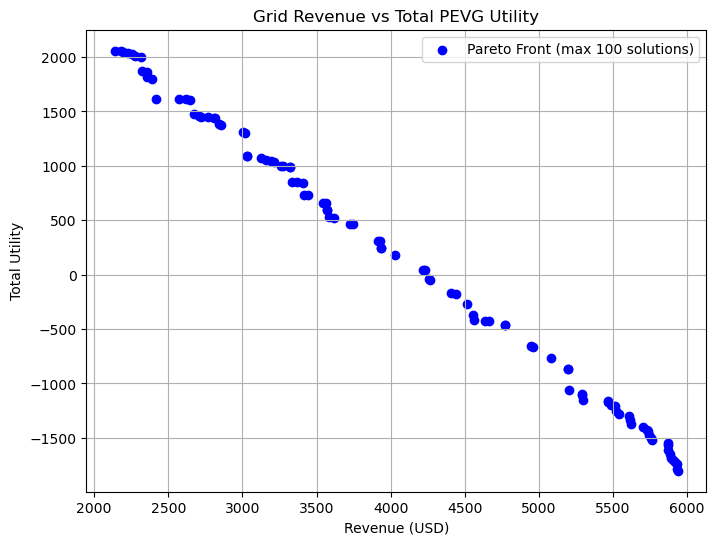


Sample Pareto Solutions:
Solution 1: Utility = 2058.04, Revenue = 2137.57
Solution 2: Utility = -1802.69, Revenue = 5940.00
Solution 3: Utility = 181.90, Revenue = 4031.01
Solution 4: Utility = -767.04, Revenue = 5084.22
Solution 5: Utility = -657.35, Revenue = 4944.28


In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_pevgs = 5
grid_capacity = 99
max_iterations = 100
population_size = 100
local_search_iterations = 10
initial_delta = 0.5  # Initial local search parameter

# Bounds
price_lower_bound = 20
price_upper_bound = 60
battery_capacity_lower_bound = 35
battery_capacity_upper_bound = 65

# Initialize random parameters
battery_capacities = np.random.uniform(battery_capacity_lower_bound, battery_capacity_upper_bound, num_pevgs)
satisfaction_parameters = np.random.uniform(1, 2, num_pevgs)

def initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound):
    population = []
    for _ in range(population_size):
        energy_demands = np.random.uniform(0, grid_capacity, num_pevgs)
        energy_demands = energy_demands / np.sum(energy_demands) * grid_capacity
        price = np.random.uniform(price_lower_bound, price_upper_bound)
        population.append((energy_demands.copy(), price))
    return population

def utility_function(energy_demands, price, battery_capacities, satisfaction_parameters):
    utilities = battery_capacities * energy_demands - 0.5 * satisfaction_parameters * energy_demands**2 - price * energy_demands
    return np.sum(utilities)

def revenue_function(energy_demands, price):
    return price * np.sum(energy_demands)

def handle_constraints(energy_demands, grid_capacity):
    total_demand = np.sum(energy_demands)
    if total_demand > grid_capacity:
        energy_demands = energy_demands / total_demand * grid_capacity
    return np.clip(energy_demands, 0, grid_capacity)

def local_search(particle, battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound):
    energy_demands, price = particle
    for _ in range(local_search_iterations):
        new_energy_demands = energy_demands + delta * np.random.uniform(-1, 1, num_pevgs)
        new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
        new_price = price + delta * np.random.uniform(-1, 1)
        new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
        new_utility = utility_function(new_energy_demands, new_price, battery_capacities, satisfaction_parameters)
        new_revenue = revenue_function(new_energy_demands, new_price)
        curr_utility = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
        curr_revenue = revenue_function(energy_demands, price)
        if dominates((new_utility, new_revenue), (curr_utility, curr_revenue)):
            energy_demands, price = new_energy_demands, new_price
    return energy_demands, price

def dominates(solution1, solution2):
    return (solution1[0] >= solution2[0] and solution1[1] >= solution2[1] and
            (solution1[0] > solution2[0] or solution1[1] > solution2[1]))

def improved_crowding_distance(pareto_front):
    """Improved crowding distance for better diversity"""
    if len(pareto_front) <= 2:
        return [float('inf')] * len(pareto_front)
    
    n = len(pareto_front)
    distances = np.zeros(n)
    objectives = np.array(pareto_front)
    
    for obj_idx in range(2):  # For utility and revenue
        # Sort by current objective
        sorted_indices = np.argsort(objectives[:, obj_idx])
        sorted_values = objectives[sorted_indices, obj_idx]
        max_val = sorted_values[-1]
        min_val = sorted_values[0]
        range_val = max_val - min_val + 1e-10
        
        # Set infinity for boundaries
        distances[sorted_indices[0]] = float('inf')
        distances[sorted_indices[-1]] = float('inf')
        
        # Calculate normalized distance for interior points
        for i in range(1, n - 1):
            dist = (sorted_values[i + 1] - sorted_values[i - 1]) / range_val
            distances[sorted_indices[i]] += dist
    
    return distances

def update_pareto_front(pareto_front, new_solution, max_size=100):
    """Update Pareto front with improved diversity, limit to max_size"""
    if not pareto_front:
        return [new_solution]
    
    to_remove = []
    dominated = False
    for i, solution in enumerate(pareto_front):
        if dominates(solution, new_solution):
            dominated = True
            break
        if dominates(new_solution, solution):
            to_remove.append(i)
    
    if not dominated:
        pareto_front = [sol for j, sol in enumerate(pareto_front) if j not in to_remove]
        pareto_front.append(new_solution)
    
    # Limit to 100 solutions with improved crowding distance
    if len(pareto_front) > max_size:
        distances = improved_crowding_distance(pareto_front)
        sorted_pairs = sorted(zip(pareto_front, distances), key=lambda x: x[1], reverse=True)
        pareto_front = [pair[0] for pair in sorted_pairs[:max_size]]
    
    return pareto_front

def calculate_charges(fitness_values):
    max_utility = max(f[0] for f in fitness_values)
    max_revenue = max(f[1] for f in fitness_values)
    charges = []
    for utility, revenue in fitness_values:
        q = np.exp(-num_pevgs * ((max_utility - utility) + (max_revenue - revenue)) /
                  (max_utility + max_revenue + 1e-10))
        charges.append(q)
    return np.array(charges)

def ema_algorithm(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, population_size, max_iterations, initial_delta, price_lower_bound, price_upper_bound):
    population = initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound)
    pareto_front = []
    
    for iteration in range(max_iterations):
        # Adaptive delta: decreases over iterations to refine search
        delta = initial_delta * (1 - iteration / max_iterations)
        
        # Evaluate fitness
        fitness_values = []
        for energy_demands, price in population:
            utility = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
            revenue = revenue_function(energy_demands, price)
            fitness_values.append((utility, revenue))
        
        # Update Pareto front
        for fitness in fitness_values:
            pareto_front = update_pareto_front(pareto_front, fitness, max_size=100)
        
        # Calculate charges
        charges = calculate_charges(fitness_values)
        
        # Calculate forces
        forces = []
        for i in range(population_size):
            force = np.zeros(num_pevgs + 1)
            for j in range(population_size):
                if i != j and charges[j] > charges[i]:
                    particle_j = np.concatenate((population[j][0], [population[j][1]]))
                    particle_i = np.concatenate((population[i][0], [population[i][1]]))
                    diff = particle_j - particle_i
                    dist = np.linalg.norm(diff) + 1e-10
                    force += charges[j] * diff / dist**2
            forces.append(force)
        
        # Move particles
        for i in range(population_size):
            energy_demands, price = population[i]
            force = forces[i]
            new_energy_demands = energy_demands + delta * force[:-1]
            new_price = price + delta * force[-1]
            new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
            new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
            population[i] = (new_energy_demands, new_price)
        
        # Local search with adaptive delta
        for i in range(population_size):
            population[i] = local_search(population[i], battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound)
        
        if iteration % 20 == 0:
            print(f"Iteration {iteration}: Pareto front size = {len(pareto_front)}, Delta = {delta:.4f}")
    
    return pareto_front, population

# Run EMA algorithm
pareto_front, particles = ema_algorithm(
    num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters,
    population_size, max_iterations, initial_delta, price_lower_bound, price_upper_bound
)

# Extract X (revenue) and Y (utility) for plotting
X = [sol[1] for sol in pareto_front]
Y = [sol[0] for sol in pareto_front]

# Plot Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, color="b", label="Pareto Front (max 100 solutions)")
plt.title("Grid Revenue vs Total PEVG Utility")
plt.xlabel("Revenue (USD)")
plt.ylabel("Total Utility")
plt.legend()
plt.grid(True)
plt.show()

# Print sample solutions
print("\nSample Pareto Solutions:")
for i, (utility, revenue) in enumerate(pareto_front[:5]):
    print(f"Solution {i+1}: Utility = {utility:.2f}, Revenue = {revenue:.2f}")

In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Parameters
num_pevgs = 5
grid_capacity = 99
max_iterations = 100
population_size = 100
local_search_iterations = 10
initial_delta = 0.8

# Bounds
price_lower_bound = 20
price_upper_bound = 60
battery_capacity_lower_bound = 35
battery_capacity_upper_bound = 65

# Initialize random parameters
battery_capacities = np.random.uniform(battery_capacity_lower_bound, battery_capacity_upper_bound, num_pevgs)
satisfaction_parameters = np.random.uniform(1, 2, num_pevgs)

def initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound):
    population = []
    for _ in range(population_size):
        energy_demands = np.random.uniform(0, grid_capacity, num_pevgs)
        energy_demands = energy_demands / np.sum(energy_demands) * grid_capacity
        price = np.random.uniform(price_lower_bound, price_upper_bound)
        population.append((energy_demands.copy(), price))
    return population

def utility_function(energy_demands, price, battery_capacities, satisfaction_parameters):
    utilities = battery_capacities * energy_demands - 0.5 * satisfaction_parameters * energy_demands**2 - price * energy_demands
    return np.sum(utilities)

def revenue_function(energy_demands, price):
    return price * np.sum(energy_demands)

def handle_constraints(energy_demands, grid_capacity):
    total_demand = np.sum(energy_demands)
    if total_demand > grid_capacity:
        energy_demands = energy_demands / total_demand * grid_capacity
    return np.clip(energy_demands, 0, grid_capacity)

def local_search(particle, battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound):
    energy_demands, price = particle
    for _ in range(local_search_iterations):
        new_energy_demands = energy_demands + delta * np.random.uniform(-1, 1, num_pevgs)
        new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
        new_price = price + delta * np.random.uniform(-1, 1)
        new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
        new_utility = utility_function(new_energy_demands, new_price, battery_capacities, satisfaction_parameters)
        new_revenue = revenue_function(new_energy_demands, new_price)
        curr_utility = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
        curr_revenue = revenue_function(energy_demands, price)
        if dominates((new_utility, new_revenue), (curr_utility, curr_revenue)):
            energy_demands, price = new_energy_demands, new_price
    return energy_demands, price

def dominates(solution1, solution2):
    return (solution1[0] >= solution2[0] and solution1[1] >= solution2[1] and
            (solution1[0] > solution2[0] or solution1[1] > solution2[1]))

def improved_crowding_distance(pareto_front):
    """Improved crowding distance for better diversity"""
    if len(pareto_front) <= 2:
        return [float('inf')] * len(pareto_front)
    
    n = len(pareto_front)
    distances = np.zeros(n)
    objectives = np.array(pareto_front)
    
    for obj_idx in range(2):
        sorted_indices = np.argsort(objectives[:, obj_idx])
        sorted_values = objectives[sorted_indices, obj_idx]
        max_val = sorted_values[-1]
        min_val = sorted_values[0]
        range_val = max_val - min_val + 1e-10
        
        distances[sorted_indices[0]] = float('inf')
        distances[sorted_indices[-1]] = float('inf')
        
        for i in range(1, n - 1):
            dist = (sorted_values[i + 1] - sorted_values[i - 1]) / range_val
            distances[sorted_indices[i]] += dist
    
    return distances

def initialize_pareto_front(fitness_values, max_size=100):
    """Initialize Pareto front with exactly max_size solutions"""
    # Start with all fitness values
    pareto_front = []
    for fitness in fitness_values:
        to_remove = []
        dominated = False
        for i, solution in enumerate(pareto_front):
            if dominates(solution, fitness):
                dominated = True
                break
            if dominates(fitness, solution):
                to_remove.append(i)
        if not dominated:
            pareto_front = [sol for j, sol in enumerate(pareto_front) if j not in to_remove]
            pareto_front.append(fitness)
    
    # If less than max_size, pad with duplicates of best solutions (optional)
    if len(pareto_front) < max_size:
        sorted_front = sorted(pareto_front, key=lambda x: x[0] + x[1], reverse=True)
        while len(pareto_front) < max_size:
            pareto_front.append(sorted_front[0])  # Duplicate best solution
    
    # If more than max_size, prune using crowding distance
    if len(pareto_front) > max_size:
        distances = improved_crowding_distance(pareto_front)
        sorted_pairs = sorted(zip(pareto_front, distances), key=lambda x: x[1], reverse=True)
        pareto_front = [pair[0] for pair in sorted_pairs[:max_size]]
    
    return pareto_front

def update_pareto_front(pareto_front, new_solution, max_size=100):
    """Update fixed-size Pareto front"""
    # Temporarily add new solution
    temp_front = pareto_front + [new_solution]
    # Remove dominated solutions
    to_remove = []
    for i, solution in enumerate(temp_front):
        for j, other in enumerate(temp_front):
            if i != j and dominates(other, solution):
                to_remove.append(i)
                break
    temp_front = [sol for j, sol in enumerate(temp_front) if j not in set(to_remove)]
    
    # If size exceeds max_size, prune with crowding distance
    if len(temp_front) > max_size:
        distances = improved_crowding_distance(temp_front)
        sorted_pairs = sorted(zip(temp_front, distances), key=lambda x: x[1], reverse=True)
        return [pair[0] for pair in sorted_pairs[:max_size]]
    # If size is less than max_size (unlikely after initialization), pad with best
    elif len(temp_front) < max_size:
        sorted_front = sorted(temp_front, key=lambda x: x[0] + x[1], reverse=True)
        while len(temp_front) < max_size:
            temp_front.append(sorted_front[0])
        return temp_front
    return temp_front

def calculate_charges(fitness_values):
    max_utility = max(f[0] for f in fitness_values)
    max_revenue = max(f[1] for f in fitness_values)
    charges = []
    for utility, revenue in fitness_values:
        q = np.exp(-num_pevgs * ((max_utility - utility) + (max_revenue - revenue)) /
                  (max_utility + max_revenue + 1e-10))
        charges.append(q)
    return np.array(charges)

def ema_algorithm(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, population_size, max_iterations, initial_delta, price_lower_bound, price_upper_bound):
    population = initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound)
    pareto_front = None
    
    for iteration in range(max_iterations):
        delta = initial_delta * (1 - iteration / max_iterations)
        
        # Evaluate fitness
        fitness_values = []
        for energy_demands, price in population:
            utility = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
            revenue = revenue_function(energy_demands, price)
            fitness_values.append((utility, revenue))
        
        # Initialize Pareto front in first iteration
        if iteration == 0:
            pareto_front = initialize_pareto_front(fitness_values, max_size=100)
        # Update Pareto front in subsequent iterations
        else:
            for fitness in fitness_values:
                pareto_front = update_pareto_front(pareto_front, fitness, max_size=100)
        
        # Calculate charges
        charges = calculate_charges(fitness_values)
        
        # Calculate forces
        forces = []
        for i in range(population_size):
            force = np.zeros(num_pevgs + 1)
            for j in range(population_size):
                if i != j and charges[j] > charges[i]:
                    particle_j = np.concatenate((population[j][0], [population[j][1]]))
                    particle_i = np.concatenate((population[i][0], [population[i][1]]))
                    diff = particle_j - particle_i
                    dist = np.linalg.norm(diff) + 1e-10
                    force += charges[j] * diff / dist**2
            forces.append(force)
        
        # Move particles
        for i in range(population_size):
            energy_demands, price = population[i]
            force = forces[i]
            new_energy_demands = energy_demands + delta * force[:-1]
            new_price = price + delta * force[-1]
            new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
            new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
            population[i] = (new_energy_demands, new_price)
        
        # Local search
        for i in range(population_size):
            population[i] = local_search(population[i], battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound)
        
        if iteration % 20 == 0:
            print(f"Iteration {iteration}: Pareto front size = {len(pareto_front)}, Delta = {delta:.4f}")
    
    return pareto_front, population

# Run EMA algorithm
pareto_front, particles = ema_algorithm(
    num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters,
    population_size, max_iterations, initial_delta, price_lower_bound, price_upper_bound
)

# Extract X (revenue) and Y (utility) for plotting
X = [sol[1] for sol in pareto_front]
Y = [sol[0] for sol in pareto_front]


Iteration 0: Pareto front size = 100, Delta = 0.8000
Iteration 20: Pareto front size = 100, Delta = 0.6400
Iteration 40: Pareto front size = 100, Delta = 0.4800
Iteration 60: Pareto front size = 100, Delta = 0.3200
Iteration 80: Pareto front size = 100, Delta = 0.1600


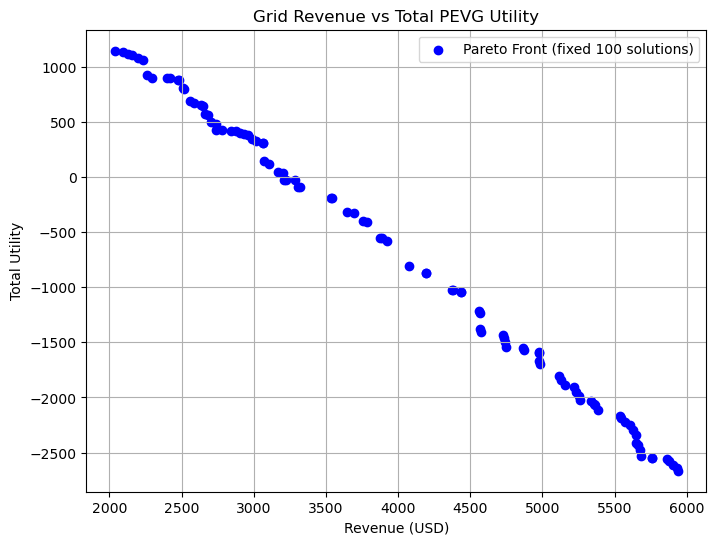


Sample Pareto Solutions:
Solution 1: Utility = 1145.80, Revenue = 2036.27
Solution 2: Utility = -2664.81, Revenue = 5940.00
Solution 3: Utility = -808.17, Revenue = 4073.41
Solution 4: Utility = -577.99, Revenue = 3926.39
Solution 5: Utility = -1026.77, Revenue = 4375.66


In [12]:
# Plot Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, color="b", label="Pareto Front (fixed 100 solutions)")
plt.title("Grid Revenue vs Total PEVG Utility")
plt.xlabel("Revenue (USD)")
plt.ylabel("Total Utility")
plt.legend()
plt.grid(True)
plt.show()

# Print sample solutions
print("\nSample Pareto Solutions:")
for i, (utility, revenue) in enumerate(pareto_front[:5]):
    print(f"Solution {i+1}: Utility = {utility:.2f}, Revenue = {revenue:.2f}")